In [560]:
import os, re
from os.path import isdir, join, exists, abspath
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
%matplotlib notebook

# Load documents and scrutinize unwanted punctuations
**Load document labels**

In [347]:
raw_path = u'./corpus/raw-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(raw_path) if isdir(join(raw_path, fn))] # list only folders
print 'Showing one sample document label'
print 'Unicode codepoints representation:', repr(doc_labels[0]), '::', type(doc_labels[0])
print 'The actual glyph (appearance):', doc_labels[0]

Showing one sample document label
Unicode codepoints representation: u'\u0e1b\u0e23\u0e30\u0e21\u0e07' :: <type 'unicode'>
The actual glyph (appearance): ประมง


**Show all document labels**

In [291]:
doc_labels_idx = {} # maps label name to its corresponding index
print 'Total labels:', len(doc_labels)
for i, label in enumerate(doc_labels):
    doc_labels_idx[label] = i
    print "%d: %s" % (i, label)

Total labels: 15
0: ประมง
1: มนุษยศาสตร์
2: วนศาสตร์
3: วิทยาศาสตร์
4: วิทยาศาสตร์การกีฬา
5: วิศวกรรมศาสตร์ กำแพงแสน
6: ศึกษาศาสตร์
7: สังคมศาสตร์
8: สัตวแพทยศาสตร์
9: สิ่งแวดล้อม
10: อุตสาหกรรมเกษตร
11: เกษตร
12: เกษตร กำแพงแสน
13: เศรษฐศาสตร์
14: โครงการสหวิทยาการระดับบัณฑิตศึกษา


**Open documents from each folder**

In [709]:
%%time
label_freqs = []
dataset_contents, dataset_labels, dataset_filenames, content_lengths = [], [], [], [] # will be used later
for i, label in enumerate(doc_labels):
    curr_dir = join(raw_path, label)
    fns = os.listdir(curr_dir)
#     print len(fns), label
    label_freqs.append(len(fns))
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            content_lengths.append(len(content))
            dataset_contents.append(content)
            dataset_labels.append(i)
            dataset_filenames.append(fn)

Wall time: 209 ms


**Show number of files in each folder**

<IPython.core.display.Javascript object>


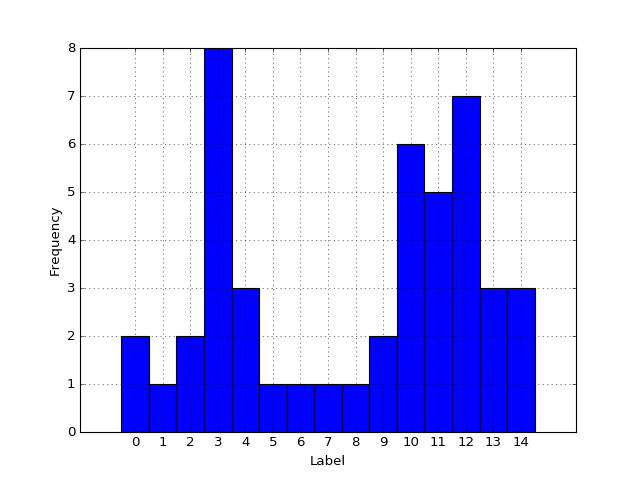

In [674]:
plt.figure()
plt.bar(np.arange(len(doc_labels))-0.5, label_freqs, 1)
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid()
plt.show()

**Show dataset statistics**

In [675]:
print 'Total documents:', len(dataset_contents)
print 'Label Frequencies:', label_freqs
print 'Label Frequencies Mean:', np.mean(label_freqs)
print 'Content Lengths Mean:', np.mean(content_lengths)

Total documents: 46
Label Frequencies: [2, 1, 2, 8, 3, 1, 1, 1, 1, 2, 6, 5, 7, 3, 3]
Label Frequencies Mean: 3.06666666667
Content Lengths Mean: 585066.652174


**Remove outliers**

In [513]:
# idx = np.argmax(content_lengths)
# del content_lengths[idx]
# del dataset_contents[idx]
# del dataset_labels[idx]

**Show histogram of all contents' length**

<IPython.core.display.Javascript object>


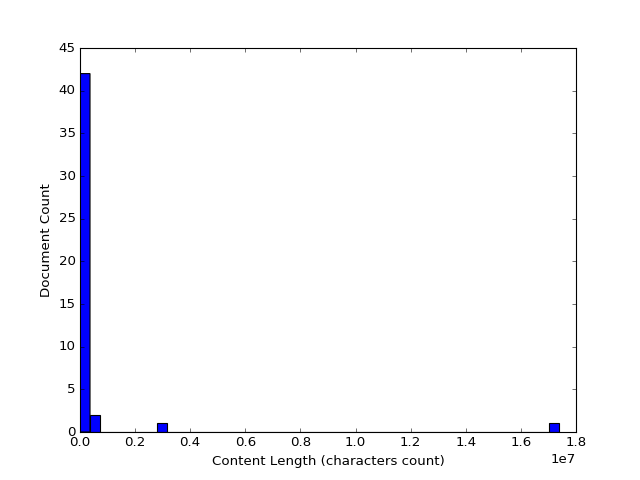

In [676]:
plt.figure()
plt.hist(content_lengths, bins=50)
plt.xlabel('Content Length (characters count)')
plt.ylabel('Document Count')
plt.show()

## Scrutinize unwanted punctuations
**Define scrutinize() function**

In [708]:
punctuations = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\r\n\t')
scrutinize = lambda s: ''.join(c for c in s if c not in punctuations) # remove all punctuations inside s

**Sample Original Content**

In [710]:
sample = dataset_contents[1][:2**8]
print sample
sample

I49620305
Ipage 
Iวิทยานิพนธ์
Pการศึกษาคุณลักษณะ complementary dnas (cdnas) และการแสดงออกของยีน anti-lipopolysaccharide factors ในกุ้งก้ามกราม (macrobrachium rosenbergii, de man)
Pmolecular characterization of complementary dnas (cdnas) and expression of a


u'I49620305\nIpage \nI\u0e27\u0e34\u0e17\u0e22\u0e32\u0e19\u0e34\u0e1e\u0e19\u0e18\u0e4c\nP\u0e01\u0e32\u0e23\u0e28\u0e36\u0e01\u0e29\u0e32\u0e04\u0e38\u0e13\u0e25\u0e31\u0e01\u0e29\u0e13\u0e30 complementary dnas (cdnas) \u0e41\u0e25\u0e30\u0e01\u0e32\u0e23\u0e41\u0e2a\u0e14\u0e07\u0e2d\u0e2d\u0e01\u0e02\u0e2d\u0e07\u0e22\u0e35\u0e19 anti-lipopolysaccharide factors \u0e43\u0e19\u0e01\u0e38\u0e49\u0e07\u0e01\u0e49\u0e32\u0e21\u0e01\u0e23\u0e32\u0e21 (macrobrachium rosenbergii, de man)\nPmolecular characterization of complementary dnas (cdnas) and expression of a'

**Sample Content Scrutinized**

In [711]:
scrutinized = scrutinize(sample)
print scrutinized
scrutinized

I49620305Ipage Iวิทยานิพนธ์Pการศึกษาคุณลักษณะ complementary dnas cdnas และการแสดงออกของยีน antilipopolysaccharide factors ในกุ้งก้ามกราม macrobrachium rosenbergii de manPmolecular characterization of complementary dnas cdnas and expression of a


u'I49620305Ipage I\u0e27\u0e34\u0e17\u0e22\u0e32\u0e19\u0e34\u0e1e\u0e19\u0e18\u0e4cP\u0e01\u0e32\u0e23\u0e28\u0e36\u0e01\u0e29\u0e32\u0e04\u0e38\u0e13\u0e25\u0e31\u0e01\u0e29\u0e13\u0e30 complementary dnas cdnas \u0e41\u0e25\u0e30\u0e01\u0e32\u0e23\u0e41\u0e2a\u0e14\u0e07\u0e2d\u0e2d\u0e01\u0e02\u0e2d\u0e07\u0e22\u0e35\u0e19 antilipopolysaccharide factors \u0e43\u0e19\u0e01\u0e38\u0e49\u0e07\u0e01\u0e49\u0e32\u0e21\u0e01\u0e23\u0e32\u0e21 macrobrachium rosenbergii de manPmolecular characterization of complementary dnas cdnas and expression of a'

**Scrutinize all contents**

In [712]:
%%time
for i in xrange(len(dataset_contents)):
    dataset_contents[i] = scrutinize(dataset_contents[i])
    content_lengths[i] = len(dataset_contents[i])
print 'New Content Lengths Mean:', np.mean(content_lengths)

New Content Lengths Mean: 505169.978261
Wall time: 4.26 s


**New Content Lengths after Scrutinizing**

<IPython.core.display.Javascript object>


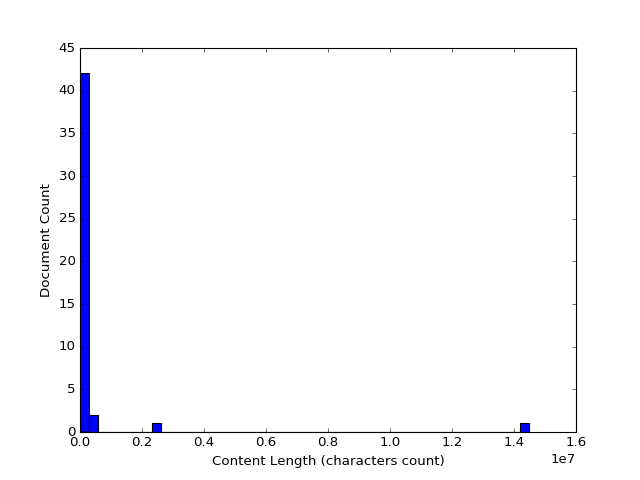

In [713]:
plt.figure()
plt.hist(content_lengths, bins=50)
plt.xlabel('Content Length (characters count)')
plt.ylabel('Document Count')
plt.show()

**Save scrutinized contents**

In [714]:
%%time
scrutinized_path = './corpus/scrutinized-docs'
for content, label, fn in zip(dataset_contents, dataset_labels, dataset_filenames):
    str_label = doc_labels[label]
    folder_path = join(scrutinized_path, str_label)
    if not exists(folder_path):
        os.makedirs(folder_path)
    file_path = join(folder_path, fn)
    with open(file_path, 'w') as f:
        f.write(content.encode('utf8'))
del dataset_contents

Wall time: 527 ms


# Segment each document and save them
**Create new folders if necessary**

In [545]:
segmented_path = u'./corpus/segmented-docs'
for label in doc_labels:
    folder_path = join(segmented_path, label)
    if not exists(folder_path):
        os.makedirs(folder_path)
        print 'New folder', folder_path

** Create temporary paths file then call Java LongLexTo on that file to segment all documents**

In [715]:
%%time
try:
    os.chdir('LongLexTo')
except:
    pass
print os.getcwdu()
tmp_paths = u'tmp_paths.txt'
tmp_output = u'tmp_output.txt'
with open(tmp_paths, 'w') as f:
    contents = []
    for label, fn in zip(dataset_labels, dataset_filenames):
        str_label = doc_labels[label]
        ifp = join('..', scrutinized_path, str_label, fn) # input file path
        ofp = join('..', segmented_path, str_label, fn) # output file path
        if not isfile(ifp):
            print 'Error:', ifp, ofp
            raise AssertionError('input file path is invalid')
        content = ifp + u'\n' + ofp + u'\n'
        contents.append(content)
    content = u'q\n'
    contents.append(content)
    f.write(''.join(contents).encode('utf8'))
print 'Running...'
return_code = call(u'java LongLexTo -Dfile.encoding=UTF-8 < %s > %s' % (tmp_paths, tmp_output), shell=True)
print 'return code:', return_code
print 'Please see %s and %s for more info' % (tmp_paths, tmp_output)
if return_code:
    print 'You may need to call the Java commmand yourself because I failed'
    print 'The paths creation process was successful but the segmentation went wrong'
    print 'Go into the folder LongLexTo, open a shell then type the following command'
    print 'java -Dfile.encoding=UTF-8 LongLexTo < tmp_paths.txt'
    print 'Wait a minute and go check at the segmented-docs folder to see if the segmentation went right.'
    print 'The file will be encoded in UTF-8 and there will be no punctuations in each file.'
os.chdir('..')

D:\off99555\Documents\GitHub\Thai-thesis-classification\LongLexTo
Running...
return code: 1
Please see tmp_paths.txt and tmp_output.txt for more info
You may need to call the Java commmand yourself because I failed
The paths creation process was successful but the segmentation went wrong
Go into the folder LongLexTo, open a shell then type the following command
java -Dfile.encoding=UTF-8 LongLexTo < tmp_paths.txt
Wait a minute and go check at the segmented-docs folder to see if the segmentation went right.
The file will be encoded in UTF-8 and there will be no punctuations in each file.
Wall time: 305 ms
